В цій практичній роботі ми спробуємо реалізувати нейронну мережу з двох шарів (прихований і вихідний). Запропонований підхід стане заготовкою для реалізації наступних оптимізацій: MBGD, ADAM та регуляризації. 

Сьогодні ж вам пропонується додати до цього класу підтримку довільної кількості шарів та нейронів в них (наприклад, передавати їх параметром в конструктор, як це робиться в MLPClassifier за допомогою hidden_layer_sizes). Також потрібно передбачити можливість ранньої зупинки ітераційного процесу, якщо значення штрафної функції не покращуватиметься протягом певної кількості ітерацій. Наприклад, якщо протягом $k$ ітерацій штрафна функція за модулем не стане меншою, ніж на поточному кроці.

In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical

import sklearn.linear_model

Using TensorFlow backend.


In [651]:
class NeuralNet:
    
    
    def __init__(self, normalize = True, learning_rate = 0.01, max_iter = 30000, hidden_layer_sizes=(100,), epsilon=1e-6):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.normalize = normalize
        self.hidden_layer_sizes = hidden_layer_sizes
        self.n_layers = 1 + len(hidden_layer_sizes)
        self.epsilon = epsilon
    
    def __normalize(self, X, mean = None, std = None):
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s**2
        return X_new, m, s

    def __sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z))
        return expZ / expZ.sum(axis=0, keepdims=True)
    
    def __initialize_parameters(self, n_x, hidden_layers, n_y):
        np.random.seed(1)
        W = list()
        b = list()
        
        h = list(hidden_layers)
        h.insert(0, n_x)
        h.append(n_y)
        hidden_layers = tuple(h)
        
        for i in range(1, self.n_layers+1):
            W.append(np.random.randn(hidden_layers[i], hidden_layers[i-1]) / np.sqrt(
                hidden_layers[i - 1]))
            b.append(np.zeros((hidden_layers[i], 1)))

        self.parameters = {"W" : W, "b" : b}
    
    def __forward_propagation(self, X):
        W = self.parameters["W"]
        b = self.parameters["b"]

        A = list()
        Z = list()
               
        for i in range(0, self.n_layers-1):
            if i == 0:
                Z.append(np.dot(W[i], X) + b[i])
            else:
                Z.append(np.dot(W[i], A[i-1]) + b[i])
            A.append(self.__sigmoid(Z[i]))
        
        Z.append(np.dot(W[-1], A[-1]) + b[-1])
        A.append(self.softmax(Z[-1]))
        
        cache = (W, b, Z, A)

        return A[-1], cache
    
    def __sigmoid_derivative(self, Z):
        s = 1 / (1 + np.exp(-Z))
        return np.multiply(s, (1 - s))
    
    def cross_entropy(self, A, Y):
        return - np.sum(np.log(A) * (Y), axis=1)
    
    def compute_cost(self, A, Y):
        J = -np.mean(Y.T * np.log(A.T+ 1e-8))
        return J
        
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        n = X.shape[0]
        (W, b, Z, A) = cache
        
        dW = [None] * (self.n_layers)
        dA = [None] * (self.n_layers)
        dZ = [None] * (self.n_layers)
        db = [None] * (self.n_layers)
        
        dZ[-1] = (A[-1] - Y)
        dW[-1] = (1. / m * np.dot(dZ[-1], A[-2].T))
        db[-1] = (1. / m * np.sum(dZ[-1], axis = 1, keepdims = True))
        dA[-1] = np.dot(W[-1].T, dZ[-1])
        
        for i in range(self.n_layers-1, 0, -1):
            dZ[i-1] = np.multiply(dA[i], self.__sigmoid_derivative(Z[i-1]))
            if i-1 == 0:
                dW[i-1] = 1. / m * np.dot(dZ[i-1], X.T)
            else:
                dW[i-1] = 1. / m * np.dot(dZ[i-1], A[i-2].T)
            db[i-1] = 1. / m * np.sum(dZ[i-1], axis = 1, keepdims = True) 
            dA[i-1] = np.dot(W[i-1].T, dZ[i-1])
        
        grads = {"dZ" : dZ, "dW" : dW, "db" : db}
        return grads
    
    def __update_parameters(self, grads):
        W = self.parameters["W"]
        b = self.parameters["b"]

        dW = grads["dW"]
        db = grads["db"]
        
        for i in range(self.n_layers):
            W[i] = W[i] - self.learning_rate * dW[i]
            b[i] = b[i] - self.learning_rate * db[i]

    def fit(self, X_vert, Y_vert, print_cost = True):
        self.n_iter = 0
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        cost_history = []
        
        m = X.shape[1]
        n_x = X.shape[0]
        n_y = Y.shape[0]
        
        self.__initialize_parameters(n_x, self.hidden_layer_sizes, n_y)

        for i in range(self.max_iter):
            self.n_iter = i
            A, cache = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)

            grads = self.__backward_propagation(X, Y, cache)

            self.__update_parameters(grads)
            
            cost_history.append(cost)
            
            if print_cost and i % 100 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 100 == 0:
                costs.append(cost)
  
            if i > 1 and abs(cost-cost_history[-2]) < self.epsilon:
                break

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *100")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        
        return probs.T
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)
        y_pred = self.to_classlabel(positive_probs)
        return y_pred  

    def to_classlabel(self, z):
        return z.argmax(axis=1)

In [7]:
df = pd.read_csv('train.csv')
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df.shape

(42000, 785)

In [8]:
y = df["label"]
X = df.drop('label', axis = 1)

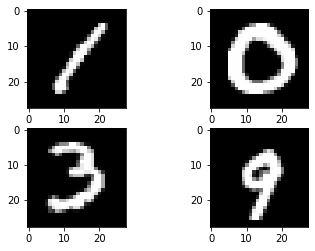

In [17]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(X.iloc[0].values.reshape(28, 28), cmap=plt.get_cmap('gray'))
axs[0, 1].imshow(X.iloc[4].values.reshape(28, 28), cmap=plt.get_cmap('gray'))
axs[1, 0].imshow(X.iloc[9].values.reshape(28, 28), cmap=plt.get_cmap('gray'))
axs[1, 1].imshow(X.iloc[28].values.reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.show()

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
print('Training set: X={}, y={}'.format(X_train.shape, y_train.shape))
print('Test set: X={}, y={}'.format(X_test.shape, y_test.shape))

Training set: X=(33600, 784), y=(33600,)
Test set: X=(8400, 784), y=(8400,)


In [25]:
#normalize
X_train = X_train / 255
X_test = X_test / 255

In [26]:
# One hot encoder
y_train = to_categorical(y_train)

In [27]:
y_train.shape

(33600, 10)

In [652]:
cls = NeuralNet(normalize = False, learning_rate = 0.1, max_iter = 1000, hidden_layer_sizes=(50, 10,), epsilon=1e-6)

In [653]:
cls.n_layers

3

0-th iteration: 0.23915385620613866
100-th iteration: 0.22755805310909075
200-th iteration: 0.22390627532798021
300-th iteration: 0.2170743652799578
400-th iteration: 0.2040941864357735
500-th iteration: 0.1840094334397615
600-th iteration: 0.16146010905972835
700-th iteration: 0.1412632213271725
800-th iteration: 0.1249788962210847
900-th iteration: 0.1123697387786823


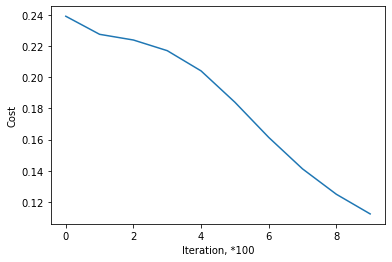

In [654]:
cls.fit(X_train, y_train)

In [655]:
cls.n_iter

999

In [656]:
print(cls.parameters)

{'W': [array([[ 0.05801233, -0.02184844, -0.01886328, ..., -0.03952047,
        -0.01282943,  0.01804935],
       [ 0.04349789, -0.06931003, -0.02879208, ...,  0.00740107,
        -0.05121538,  0.02238951],
       [ 0.01070804, -0.06630862, -0.07682297, ..., -0.06979256,
         0.00665085, -0.00013678],
       ...,
       [-0.01888887, -0.01178202,  0.00488721, ..., -0.00135933,
         0.01519459,  0.0302878 ],
       [-0.00011539, -0.02882183, -0.0291148 , ..., -0.00321773,
         0.0026965 , -0.02912119],
       [-0.01333235, -0.05263958,  0.05322715, ...,  0.02176674,
        -0.0006411 ,  0.030889  ]]), array([[-8.78610647e-02,  4.11775178e-01, -1.57631936e-01,
        -2.76080392e-01,  1.95382616e-01,  1.74061787e-03,
         3.48150161e-01,  4.15958340e-01, -3.73956807e-01,
        -9.61668145e-01,  6.11887872e-01,  2.89271944e-01,
         2.80803318e-01, -9.69579695e-02, -2.05037915e-01,
         9.38733714e-02, -1.96420512e-01,  4.64995148e-01,
         1.04293056e-01, 

In [657]:
Y_prob = cls.predict_proba(X_test)
print(Y_prob.shape)

(8400, 10)


In [658]:
Y_prob

array([[0.00462888, 0.35236618, 0.12199222, ..., 0.02643851, 0.17437454,
        0.0524323 ],
       [0.00147304, 0.62945647, 0.05828435, ..., 0.0143913 , 0.1324565 ,
        0.02205496],
       [0.00354049, 0.00678529, 0.00246488, ..., 0.45791759, 0.047764  ,
        0.31707375],
       ...,
       [0.04838862, 0.03663049, 0.1322432 , ..., 0.01299085, 0.11838627,
        0.00796496],
       [0.62892406, 0.00337951, 0.04702582, ..., 0.01404076, 0.02889977,
        0.00810473],
       [0.00351645, 0.01984729, 0.01516693, ..., 0.17253815, 0.04844282,
        0.34437345]])

In [659]:
for i in range(len(Y_prob[0])):
    print((Y_prob[0][i]))

0.004628877075771655
0.3523661785606772
0.12199222072377298
0.0629630697662469
0.04230271382752705
0.06098870284461641
0.10151289332797599
0.026438508239424226
0.1743745389946007
0.05243229663938679


In [660]:
Y_prob[0][0:10].sum()

0.9999999999999999

In [661]:
Y_hat = cls.predict(X_test)
Y_hat

array([1, 1, 7, ..., 3, 0, 9], dtype=int64)

In [662]:
accuracy_score(y_test, Y_hat)

0.7316666666666667